<a href="https://colab.research.google.com/github/alemack/ts-patching-experiments/blob/main/notebooks/fordb_patching_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [57]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [58]:
import numpy as np
import os, glob
import pandas as pd
from numpy.fft import rfft
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_fscore_support

In [59]:
base = "/content/drive/MyDrive/Colab Notebooks/FordB"
print("Exists:", os.path.exists(base))
print("Files:", *sorted(glob.glob(base+"/*")), sep="\n")

Exists: True
Files:
/content/drive/MyDrive/Colab Notebooks/FordB/Actual Var1.ipynb
/content/drive/MyDrive/Colab Notebooks/FordB/FordB.txt
/content/drive/MyDrive/Colab Notebooks/FordB/FordB_TEST.arff
/content/drive/MyDrive/Colab Notebooks/FordB/FordB_TEST.ts
/content/drive/MyDrive/Colab Notebooks/FordB/FordB_TEST.txt
/content/drive/MyDrive/Colab Notebooks/FordB/FordB_TRAIN.arff
/content/drive/MyDrive/Colab Notebooks/FordB/FordB_TRAIN.ts
/content/drive/MyDrive/Colab Notebooks/FordB/FordB_TRAIN.txt
/content/drive/MyDrive/Colab Notebooks/FordB/fordb_f1_vs_L_strideL_mean.png
/content/drive/MyDrive/Colab Notebooks/FordB/fordb_fine_results_strideL_mean.csv
/content/drive/MyDrive/Colab Notebooks/FordB/old.ipynb


In [60]:
train_path = f"{base}/FordB_TRAIN.txt"
test_path  = f"{base}/FordB_TEST.txt"

# 1) Быстрый просмотр первых 2 строк (как текст)
with open(train_path, "r") as f:
    for _ in range(2):
        print(f.readline()[:200])  # 200 символов, чтобы не засорять вывод

# 2) Загрузка как числа
train = np.loadtxt(train_path)
test  = np.loadtxt(test_path)

print("TRAIN shape:", train.shape)  # ожидаем (3636, 501) -> 1 метка + 500 значений
print("TEST  shape:", test.shape)   # ожидаем (810, 501)

y_train = train[:, 0]
X_train = train[:, 1:]
y_test  = test[:, 0]
X_test  = test[:, 1:]

print("X_train:", X_train.shape, "y_train unique:", np.unique(y_train))
print("X_test :", X_test.shape,  "y_test unique:", np.unique(y_test))
print("Series length:", X_train.shape[1])


   1.0000000e+00  -7.3126908e-01  -3.3170917e-01   1.8021198e-01   7.2935568e-01   1.2267202e+00   1.5848643e+00   1.7190977e+00   1.6224040e+00   1.3496154e+00   9.5758584e-01   5.1770889e-01   8.550
  -1.0000000e+00   1.6259232e+00   1.1748872e+00   6.3355733e-01   9.7815282e-02  -3.2397894e-01  -5.2268152e-01  -5.0107844e-01  -3.0993678e-01  -5.3305364e-02   7.4494560e-02   5.6764086e-02  -1.080
TRAIN shape: (3636, 501)
TEST  shape: (810, 501)
X_train: (3636, 500) y_train unique: [-1.  1.]
X_test : (810, 500) y_test unique: [-1.  1.]
Series length: 500


In [61]:
def to01(y):
    u = np.unique(y)
    if set(u) == {-1.0, 1.0}:
        return (y == 1.0).astype(int)
    if set(u) == {1.0, 2.0}:
        return (y == 2.0).astype(int)
    return y

y_train01 = to01(y_train)
y_test01  = to01(y_test)

print("Unique y_train01:", np.unique(y_train01), "Unique y_test01:", np.unique(y_test01))


Unique y_train01: [0 1] Unique y_test01: [0 1]


In [62]:
def zscore_per_series(X):
    """
    X: (n_series, T)
    Возвращает нормализованный X, где каждая серия имеет mean=0 и std=1.
    """
    mu = X.mean(axis=1, keepdims=True)
    sd = X.std(axis=1, keepdims=True)
    sd = np.where(sd < 1e-8, 1.0, sd)  # защита от деления на 0
    return (X - mu) / sd


In [63]:
def make_patches_no_overlap(X, y, L):
    """
    X: (n_series, T), y: (n_series,)
    Возвращает:
      Xp: (n_series*K, L)  - все патчи
      yp: (n_series*K,)    - метка для каждого патча (наследуется от ряда)
      series_id: (n_series*K,) - номер исходного ряда для каждого патча
      K: число патчей на ряд
    """
    # на данный момент хвост отбрасывается
    n, T = X.shape
    K = T // L  # сколько патчей по L без перекрытия (для T=500)
    Xp = X[:, :K*L].reshape(n*K, L)       # (n*K, L)
    yp = np.repeat(y, K)                 # (n*K,)
    series_id = np.repeat(np.arange(n), K)  # (n*K,) - нужно для агрегации
    return Xp, yp, series_id, K


In [64]:
def patch_features(Xp, ac_lags=(1,2,4,8,16), n_fft=8):
    """
    Xp: (n_patches, L)
    Возвращает матрицу признаков: (n_patches, d)
    d = 5 (статистика) + len(ac_lags) (ACF) + n_fft (спектр)
    """
    feats = []
    for row in Xp:
        # 1) базовая статистика
        f = [row.mean(), row.std(ddof=1), row.min(), row.max(), np.median(row)]

        # 2) ACF: нормированная автокорреляция на лагах
        rc = row - row.mean()
        denom = (rc @ rc) + 1e-12
        for lag in ac_lags:
            f.append((rc[:-lag] @ rc[lag:]) / denom if lag < len(row) else 0.0)

        # 3) Спектр: амплитуды rFFT (без нулевой частоты)
        spec = np.abs(rfft(row))
        if len(spec) > 1:
            idx = np.linspace(1, len(spec)-1, num=min(n_fft, len(spec)-1), dtype=int)
            f.extend(spec[idx].tolist())
        else:
            f.extend([0.0]*n_fft)

        feats.append(f)

    return np.asarray(feats, dtype=float)


In [65]:
def aggregate_to_series(proba_patch, series_id, n_series, method="mean", threshold=0.5):
    """
    proba_patch: (n_patches,) вероятности класса 1 для патчей
    series_id:   (n_patches,) номер ряда для каждого патча
    Возвращает:
      y_pred_series: (n_series,) предсказанный класс для каждого ряда
      series_scores: (n_series,) агрегированные вероятности
    """
    if method == "mean":
        sums = np.zeros(n_series, dtype=float)
        cnts = np.zeros(n_series, dtype=int)
        for p, sid in zip(proba_patch, series_id):
            sums[sid] += p
            cnts[sid] += 1
        series_scores = sums / np.maximum(cnts, 1)

    elif method == "max":
        series_scores = np.full(n_series, -np.inf, dtype=float)
        for p, sid in zip(proba_patch, series_id):
            series_scores[sid] = max(series_scores[sid], p)
    else:
        raise ValueError("Unknown aggregation method")

    y_pred_series = (series_scores >= threshold).astype(int)
    return y_pred_series, series_scores


In [66]:
def eval_for_L(X_train, y_train01, X_test, y_test01, L, agg="mean"):
    # 1) нормализация рядов
    Xtr = zscore_per_series(X_train)
    Xte = zscore_per_series(X_test)

    # 2) патчи без перекрытия (train и test отдельно)
    Xtr_p, ytr_p, sid_tr, _ = make_patches_no_overlap(Xtr, y_train01, L)
    Xte_p, yte_p, sid_te, _ = make_patches_no_overlap(Xte, y_test01, L)

    # 3) признаки
    Ftr = patch_features(Xtr_p)
    Fte = patch_features(Xte_p)

    # 4) масштабирование признаков для LogReg
    scaler = StandardScaler()
    Ftr = scaler.fit_transform(Ftr)
    Fte = scaler.transform(Fte)

    # 5) обучение модели на train-патчах
    clf = LogisticRegression(max_iter=600, class_weight="balanced")
    clf.fit(Ftr, ytr_p)

    # 6) вероятности на test-патчах
    proba_te = clf.predict_proba(Fte)[:, 1]

    # 7) агрегация в прогноз по рядам
    y_pred_series, _ = aggregate_to_series(proba_te, sid_te, n_series=len(y_test01), method=agg)

    # 8) метрики на уровне рядов
    p, r, f1, _ = precision_recall_fscore_support(
        y_test01, y_pred_series, average="binary", zero_division=0
    )
    pm, rm, f1m, _ = precision_recall_fscore_support(
        y_test01, y_pred_series, average="macro", zero_division=0
    )

    return {
        "L": L,
        "patches_per_series": (X_train.shape[1] // L),
        "agg": agg,
        "P": p, "R": r, "F1": f1,
        "P_macro": pm, "R_macro": rm, "F1_macro": f1m
    }


In [67]:
L_list = [32, 64, 128, 256, 384]

rows = []
for L in L_list:
    rows.append(eval_for_L(X_train, y_train01, X_test, y_test01, L, agg="mean"))

df_res = pd.DataFrame(rows).sort_values("F1", ascending=False)
df_res


,L,patches_per_series,agg,P,R,F1,P_macro,R_macro,F1_macro
1,64,7,mean,0.580981,0.955990,0.722736,0.724797,0.626374,0.582557
2,128,3,mean,0.595638,0.867971,0.706468,0.671651,0.633487,0.613396
0,32,15,mean,0.553191,0.953545,0.700180,0.686120,0.584005,0.520050
4,384,1,mean,0.605948,0.797066,0.688490,0.650400,0.634194,0.625077
3,256,1,mean,0.590826,0.787286,0.675052,0.631262,0.615588,0.604793


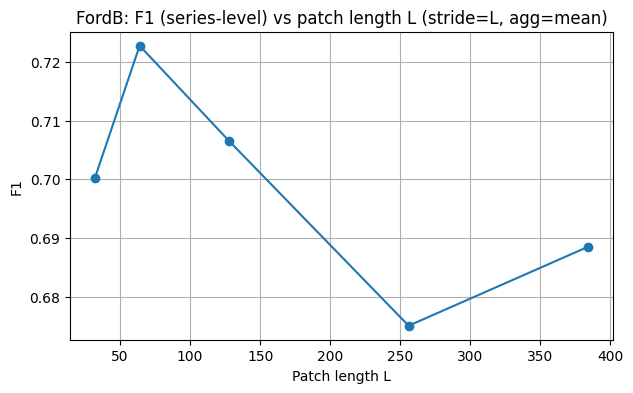

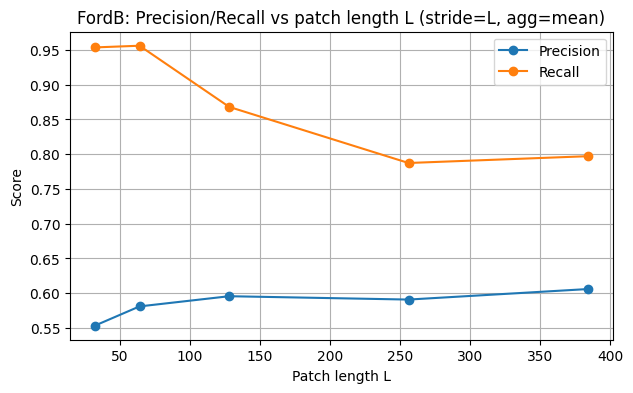

In [68]:
# 1) Подготовим данные для графиков
df_plot = df_res.sort_values("L")

# 2) График F1(L)
plt.figure(figsize=(7,4))
plt.plot(df_plot["L"], df_plot["F1"], marker="o")
plt.title("FordB: F1 (series-level) vs patch length L (stride=L, agg=mean)")
plt.xlabel("Patch length L")
plt.ylabel("F1")
plt.grid(True)
plt.show()

# 3) График Precision(L) и Recall(L)
plt.figure(figsize=(7,4))
plt.plot(df_plot["L"], df_plot["P"], marker="o", label="Precision")
plt.plot(df_plot["L"], df_plot["R"], marker="o", label="Recall")
plt.title("FordB: Precision/Recall vs patch length L (stride=L, agg=mean)")
plt.xlabel("Patch length L")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.show()


In [69]:
# Тонкая сетка вокруг лучшего L (64)
L_list_fine = [40, 48, 56, 64, 72, 80, 96, 112, 128]

rows_fine = []
for L in L_list_fine:
    rows_fine.append(eval_for_L(X_train, y_train01, X_test, y_test01, L, agg="mean"))

df_fine = pd.DataFrame(rows_fine).sort_values("F1", ascending=False)
df_fine


,L,patches_per_series,agg,P,R,F1,P_macro,R_macro,F1_macro
2,56,8,mean,0.604328,0.955990,0.740530,0.746949,0.658793,0.627357
6,96,5,mean,0.602236,0.921760,0.728502,0.714162,0.650406,0.624080
5,80,6,mean,0.595016,0.933985,0.726927,0.717151,0.642803,0.611267
3,64,7,mean,0.580981,0.955990,0.722736,0.724797,0.626374,0.582557
1,48,10,mean,0.572263,0.958435,0.716636,0.718131,0.613881,0.563641
4,72,6,mean,0.582822,0.929095,0.716305,0.699639,0.625396,0.588922
7,112,4,mean,0.599010,0.887531,0.715271,0.686760,0.640773,0.618792
0,40,12,mean,0.562857,0.963325,0.710550,0.713247,0.600116,0.541185
8,128,3,mean,0.595638,0.867971,0.706468,0.671651,0.633487,0.613396


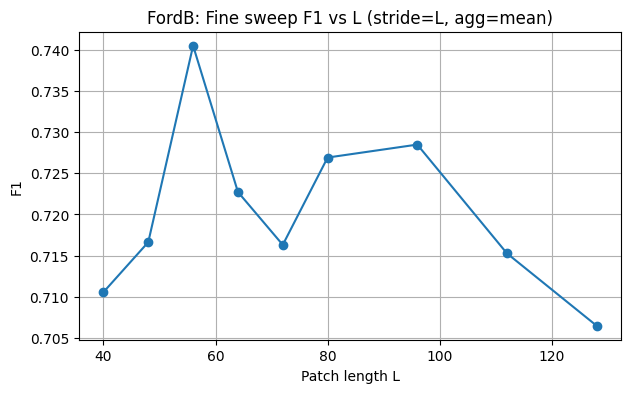

In [70]:
df_fine_plot = df_fine.sort_values("L")

plt.figure(figsize=(7,4))
plt.plot(df_fine_plot["L"], df_fine_plot["F1"], marker="o")
plt.title("FordB: Fine sweep F1 vs L (stride=L, agg=mean)")
plt.xlabel("Patch length L")
plt.ylabel("F1")
plt.grid(True)
plt.show()


Saved CSV: /content/drive/MyDrive/Colab Notebooks/FordB/fordb_fine_results_strideL_mean.csv


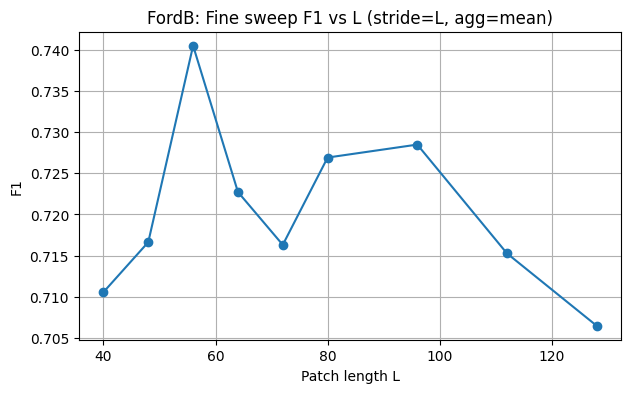

Saved PNG: /content/drive/MyDrive/Colab Notebooks/FordB/fordb_f1_vs_L_strideL_mean.png

Best by F1:
L                           56
F1                     0.74053
P                     0.604328
R                      0.95599
patches_per_series           8
agg                       mean
Name: 2, dtype: object


In [71]:
# 1) Сохраняем таблицу результатов
out_csv = f"{base}/fordb_fine_results_strideL_mean.csv"
df_fine.to_csv(out_csv, index=False)
print("Saved CSV:", out_csv)

# 2) Строим и сохраняем график
df_fine_plot = df_fine.sort_values("L")

plt.figure(figsize=(7,4))
plt.plot(df_fine_plot["L"], df_fine_plot["F1"], marker="o")
plt.title("FordB: Fine sweep F1 vs L (stride=L, agg=mean)")
plt.xlabel("Patch length L")
plt.ylabel("F1")
plt.grid(True)

out_png = f"{base}/fordb_f1_vs_L_strideL_mean.png"
plt.savefig(out_png, dpi=200, bbox_inches="tight")
plt.show()
print("Saved PNG:", out_png)

# 3) Печатаем лучший L по F1
best = df_fine.loc[df_fine["F1"].idxmax()]
print("\nBest by F1:")
print(best[["L", "F1", "P", "R", "patches_per_series", "agg"]])
